### **Camera Calibration - Zhang's Method**

##### **Paper: A Flexible New Technique for Camera Calibration**

### **Zhang's Method Implementation**

##### **Import Module**

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import least_squares

##### **Find Corner in Chess Board**

In [2]:
# Define Termination Criteria for the Iteration Algorithm - Num of Max Repeat: 30, Accuracy Error: 0.001
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

'''Find Corner Point in Chess Board'''

def get_chess_board_corner(images, num_x, num_y):
    
    images = images.copy()
    
    # Save Corner in this List 
    image_corner_coordinate = []
    
    # Repeat all of the Images
    for image in images:
        
        # Convert RGB Image to Gray Image 
        gray_scale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Find Corners in ChessBoard
        exist, corner = cv2.findChessboardCorners(image = gray_scale_image, patternSize = (num_x, num_y))

        # If Find Corners
        if exist == True:
            
            # Find More Accurate Corner
            fine_tune_corner = cv2.cornerSubPix(image = gray_scale_image, corners = corner, winSize = (11, 11), zeroZone = (-1, -1), criteria = criteria)
            fine_tune_corner = fine_tune_corner.reshape(-1, 2)
            
            image_corner_coordinate.append(fine_tune_corner)
        
    return image_corner_coordinate

##### **Draw Corners**

In [3]:
'''Visualization Corners'''


def visualize_corner(images, corner_list, num_x, num_y, save_path):
    
    for idx, image in enumerate(images):
        
        image = image.copy()
        
        # Find Corner Coordinate in the Image 
        corner = corner_list[idx]
        
        # Draw Corners
        cv2.drawChessboardCorners(image = image, patternSize = (num_x, num_y), corners = corner, patternWasFound = True)
        
        # Resize Image Size
        img = cv2.resize(image, (int(image.shape[1]), int(image.shape[0])))
        
        # Save Draw File 
        filename = save_path + "_" + str(idx) + "_draw_corner.png"
        
        cv2.imwrite(filename, img)
        
        # If Last Image 
        if idx == len(images) - 1:
            
            # Visualization
            cv2.imshow("Last Image with Drawn Corners", img)
            
            cv2.waitKey(0)
            cv2.destroyAllWindows()

##### **Operation - Find Corners & Visualization**

In [4]:
# Chess Board Image Load
image1 = cv2.imread('../../data/chess_board_data/chess_board_image_1.jpg')
image2 = cv2.imread('../../data/chess_board_data/chess_board_image_2.jpg')
image3 = cv2.imread('../../data/chess_board_data/chess_board_image_3.jpg')
image4 = cv2.imread('../../data/chess_board_data/chess_board_image_4.jpg')
image5 = cv2.imread('../../data/chess_board_data/chess_board_image_5.jpg')
image6 = cv2.imread('../../data/chess_board_data/chess_board_image_6.jpg')
image7 = cv2.imread('../../data/chess_board_data/chess_board_image_7.jpg')
image8 = cv2.imread('../../data/chess_board_data/chess_board_image_8.jpg')
image9 = cv2.imread('../../data/chess_board_data/chess_board_image_9.jpg')

# Image List
images = [image1, image2, image3, image4, image5, image6, image7, image8, image9]

# Find Corners
corner_list = get_chess_board_corner(images, 9, 6)

# Visualization & Save File 
save_path = r"../../data/chess_board_corner/"

# visualize_corner(images, corner_list, 9, 6, save_path)


### **Paper of 3.1 - Closed - Form Solution**

##### **Find World Point Coordinate**

In [4]:
'''Get Real World Coordinate'''

def get_world_points(square_length, num_y, num_x):
    
    # Make List 
    Yi, Xi = np.indices((num_y, num_x)) 
    
    offset = 0
    
    # Real World Coordinate 
    real_world_point_coordinate = np.stack(((Xi.ravel() + offset) * square_length, (Yi.ravel() + offset) * square_length)).T
    
    return real_world_point_coordinate

##### **Find H Homography Matrix**

**Homography Matrix H**는 **8 DOF**를 지니는 Matrix이며, 각 **Point**는 2개의 등식을 나타낸다. 

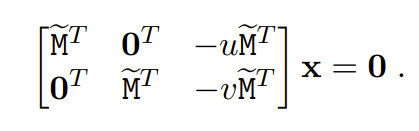

그렇기에 최소 4쌍의 Point가 존재해야 H를 구하기 위한 SVD를 계산할 수 있다. 

In [5]:
'''Calculate A Homography Matrix'''

def get_homography_matrix(real_world_coordinate, image_coordinate):
    
    num_corner = real_world_coordinate.shape[0]
    
    # Need Four Corner to Calculate SVD 
    if (num_corner < 4):
        
        print("Need More Corner to Calculate SVD")
        
        return 0
        
    # Real World Coordinate X & Y
    X = real_world_coordinate[:, 0]
    Y = real_world_coordinate[:, 1]
    
    u = image_coordinate[:, 0]
    v = image_coordinate[:, 1]
    
    L = []
    
    # Calculate L Matrix - Appendix A in Paper 
    for idx in range(num_corner):
        
        row1 = np.array([X[idx], Y[idx], 1, 0, 0, 0, -X[idx] * u[idx], -Y[idx] * u[idx], -u[idx]])
        L.append(row1)
        
        row2 = np.array([0, 0, 0, X[idx], Y[idx], 1, -X[idx] * v[idx], -Y[idx] * v[idx], -v[idx]])
        L.append(row2)

    L = np.array(L)
    
    # Calculate H with SVD
    U, E, V = np.linalg.svd(L, full_matrices = True)
    
    # Right Singular Vector 
    H = V[-1, :].reshape((3, 3))
    
    # Divide into Scale Term
    H = H / H[2,2]
    
    return H

In [6]:
'''Calculate All Homography Matrix'''

def get_all_homography_matrix(image_corner, square_length = 10, num_y = 6, num_x = 9):
    
    # Real World Corner Coordinate
    real_world_corner_coordinate = get_world_points(square_length = square_length, num_y = num_y, num_x = num_x)
    
    # Save All Homograpy Matrix
    all_homography_matrix_list = []
    
    # Image Corner Coordinate    
    for corners in image_corner:
        
        image_corner_coordinate = corners
        
        # Calculate Homography Matrix
        H = get_homography_matrix(real_world_coordinate = real_world_corner_coordinate, image_coordinate = image_corner_coordinate)

        all_homography_matrix_list.append(H)
        
    return all_homography_matrix_list
    

##### **Calculate $V_{ij}$**

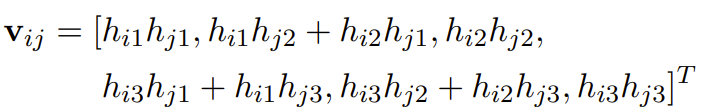

In [7]:
'''Calculate V Vector'''

def get_v_ij_vector(h_i, h_j):
    
    v_ij = np.array([h_i[0] * h_j[0], h_i[0] * h_j[1] + h_i[1] * h_j[0], h_i[1] * h_j[1], h_i[2] * h_j[0] + h_i[0] * h_j[2], h_i[2] * h_j[1] + h_i[1] * h_j[2], h_i[2] * h_j[2]]).T
    
    return v_ij

##### **Calculate V Matrix**

In [8]:
'''Calculate V Matrix'''

def get_v_matrix(all_homography_matrix_list):
    
    v_matrix = []
    
    # A Homography Matrix
    for H in all_homography_matrix_list:
        
        # First Column and Second Colunm in Homography Martix
        h_1 = H[:, 0]
        h_2 = H[:, 1]
        
        # v_ij Vector 
        v_12 = get_v_ij_vector(h_1, h_2)
        v_11 = get_v_ij_vector(h_1, h_1)
        v_22 = get_v_ij_vector(h_2, h_2)

        # Make V Matrix
        v_matrix.append(v_12.T)
        v_matrix.append((v_11 - v_22).T)       
        
    return np.array(v_matrix)

##### **Prepare B Matrix**

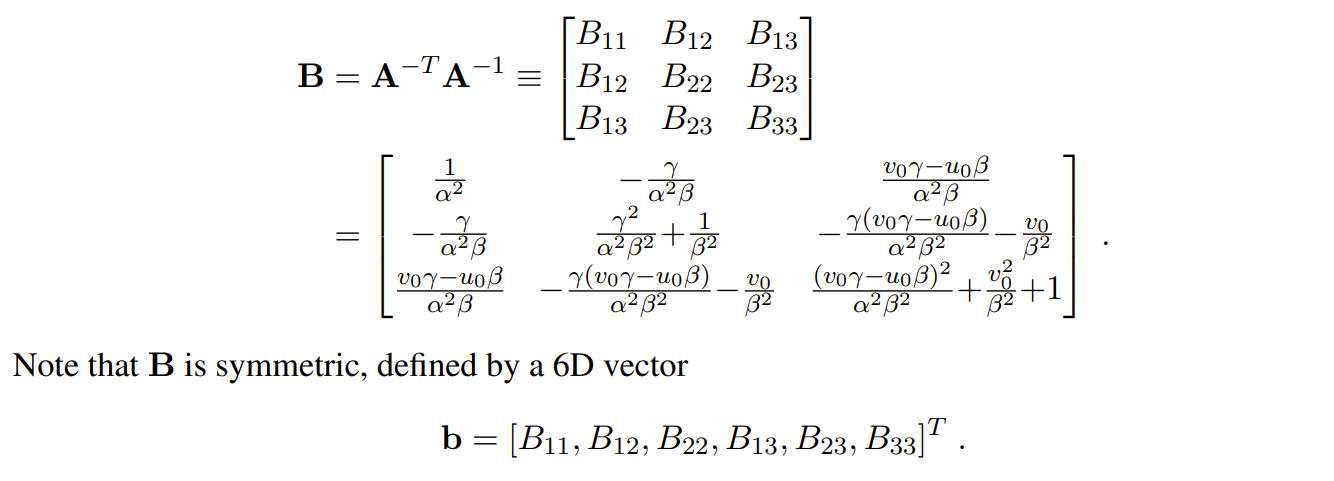

B Matrix는 Symmetric Matrix이기에 6개의 Vector로 정의할 수 있다. 

In [9]:
'''Symmetric B Matrix'''

def prepare_b_matrix(b_vector):
    
    # Initialization B Martrix
    b_matrix = np.zeros((3, 3))
    
    # B Matrix
    b_matrix[0, 0] = b_vector[0]
    b_matrix[0, 1] = b_vector[1]
    b_matrix[0, 2] = b_vector[3]
    b_matrix[1, 0] = b_vector[1]
    b_matrix[1, 1] = b_vector[2]
    b_matrix[1, 2] = b_vector[4]
    b_matrix[2, 0] = b_vector[3]
    b_matrix[2, 1] = b_vector[4]
    b_matrix[2, 2] = b_vector[5]
    
    return b_matrix

##### **Calculate V Vector and V Matrix**

In [10]:
'''Calculate B Matrix'''

def get_b_matrix_b_vector(all_homography_matrix_list):
    
    # Calculate V Matrix
    v_matrix = get_v_matrix(all_homography_matrix_list)
    
    # Calculate B Vector 
    _, _, V = np.linalg.svd(v_matrix)
    
    # Calculate B Vector 
    b_vector = V[-1, :]
    
    # Calculate B Matrix 
    b_matrix = prepare_b_matrix(b_vector)
    
    return b_matrix

##### **Calculate Camera Intrinsic Parameter**

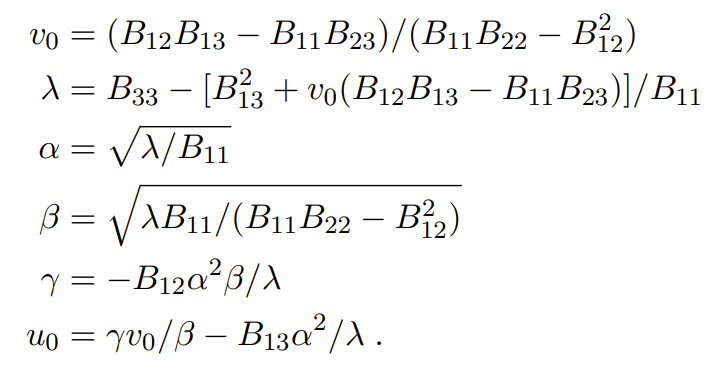

In [11]:
'''Camera Intrinsic Parameter'''

def get_intrinsic_parameter_camera(b_matrix):
    
    # Calculate Principle Point Coordinate y
    principle_point_coordinate_y = (b_matrix[0, 1] * b_matrix[0, 2] - b_matrix[0, 0] * b_matrix[1, 2]) / (b_matrix[0, 0] * b_matrix[1, 1] - b_matrix[0, 1] * b_matrix[0, 1])
    
    # Calculate Lamda - Abitrary Scale
    lamda = b_matrix[2, 2] - (b_matrix[0, 2] * b_matrix[0, 2] + principle_point_coordinate_y * (b_matrix[0, 1] * b_matrix[0, 2] - b_matrix[0, 0] * b_matrix[1, 2])) / b_matrix[0, 0]
    
    # Calculate Focal Length x
    alpha = np.sqrt((lamda / b_matrix[0, 0]))
    
    # Calculate Focal Length y
    beta = np.sqrt(lamda * b_matrix[0, 0] / (b_matrix[0, 0] * b_matrix[1, 1] - b_matrix[0, 1] * b_matrix[0, 1]))
    
    # Calculate Skewness
    gamma = -1 * b_matrix[0, 1] * alpha * alpha * beta / lamda
    
    # Calculate Principle Point Coordinate x
    principle_point_coordinate_x = (gamma * principle_point_coordinate_y / beta) - (b_matrix[0, 2] * alpha * alpha / lamda)
    
    # Intrinsic Parameter Matrix
    intrinsic_parameter_matrix = np.array([[alpha, gamma, principle_point_coordinate_x], [0, beta, principle_point_coordinate_y], [0, 0, 1]])
    
    return intrinsic_parameter_matrix

##### **Calculate Camera Extrinsic Parameter - Rotation & Translation**

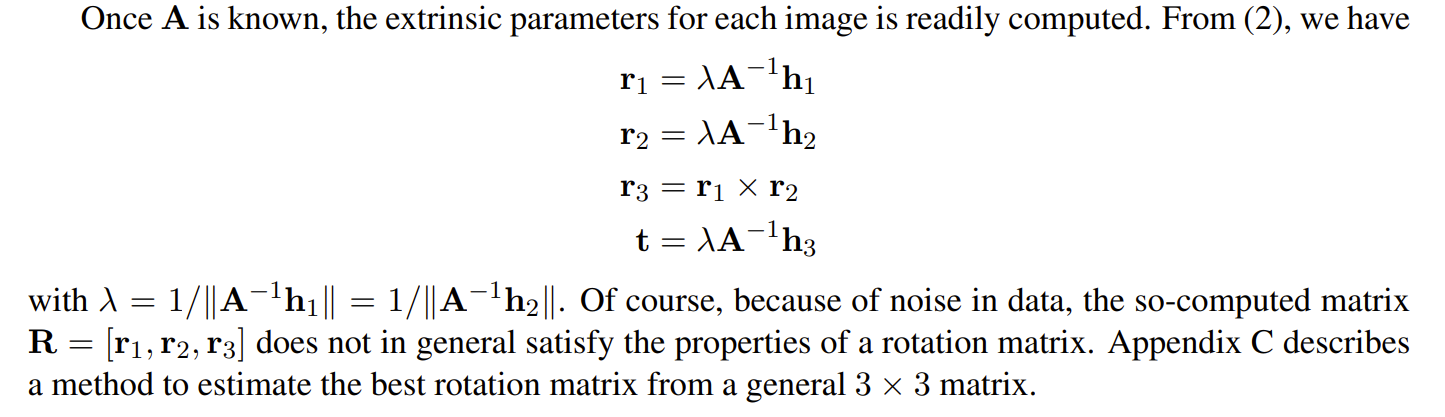

In [12]:
'''Camera Extrinsic Parameter'''

def get_extrinsic_parameter_camera(intrinsic_parameter_matrix, all_homography_matrix_list):
    
    # Extrinsic Camera Parameter Matrix in All Images
    all_extrinsic_parameter_matrix = []
    
    # Calculate Extrinsic Camera Parameter
    for h_matrix in all_homography_matrix_list:
        
        # Column Vector of H Matrix
        h_1 = h_matrix[:, 0]
        h_2 = h_matrix[:, 1]
        h_3 = h_matrix[:, 2]
        
        # Calculate Magnitude of Ratation Matrix 
        lamda = np.linalg.norm(np.dot(np.linalg.inv(intrinsic_parameter_matrix), h_1), 2)
        
        # Calculate Rotation Vector 
        r_1 = np.dot(np.linalg.inv(intrinsic_parameter_matrix), h_1) / lamda
        r_2 = np.dot(np.linalg.inv(intrinsic_parameter_matrix), h_2) / lamda
        r_3 = np.cross(r_1, r_2)
        
        # Calculate Translation Vector 
        t = np.dot(np.linalg.inv(intrinsic_parameter_matrix), h_3) / lamda
        
        # Calculate Extrinsic Camera Parameter
        extrinsic_parameter_matrix = np.vstack((r_1, r_2, r_3, t)).T
        
        all_extrinsic_parameter_matrix.append(extrinsic_parameter_matrix)
        
    return all_extrinsic_parameter_matrix

##### **Approximating a 3x3 Matrix by a Rotation Matrix**

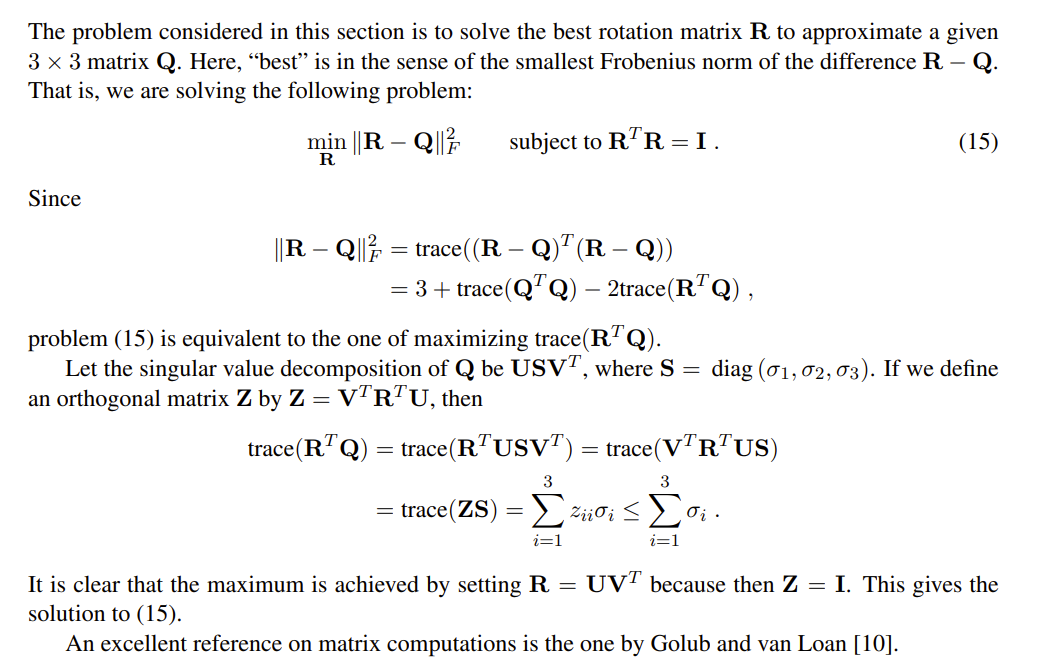

앞선 과정을 통해 구한 Extrinsic Parameter R은 Data의 Noise로 인해 Rotation Matrix의 Property를 완벽히 만족하지 못한다고 한다. 

In [13]:
'''Calculate Rotation Matrix in Extrinsic Parameter'''

def get_rotation_matrix(all_extrinsic_camera_parameter):
    
    all_rotation_matrix = []
    
    for extrinsic_camera_parameter in all_extrinsic_camera_parameter:
        
        all_rotation_matrix.append(extrinsic_camera_parameter[ : 3, : 3])
                
    return all_rotation_matrix

In [14]:
'''Calculate Best Approximation Rotation Matrix'''

def approximate_rotation_matrix(all_rotation_matrix):
    
    all_approximation_rotation_matrix = []
    
    for rotation_matrix in all_rotation_matrix:
        
        u, _, v = np.linalg.svd(rotation_matrix)
        
        approximation_rotation_matrix = np.dot(u, v.T)
        
        all_approximation_rotation_matrix.append(approximation_rotation_matrix)
        
    return all_approximation_rotation_matrix

##### **Dealing with Radial Distortion** 

In [15]:
'''Calculate Radial Distortion Coefficient'''

def get_radial_distortion_component(intrinsic_camera_parameter, radial_distortion_coefficient):
    
    # Calculate Principle Point Coordinate y
    principle_point_coordinate_y = intrinsic_camera_parameter[1, 2]
    
    # Calculate Focal Length x
    alpha = intrinsic_camera_parameter[0, 0]
    
    # Calculate Focal Length y
    beta = intrinsic_camera_parameter[1, 1]
    
    # Calculate Skewness
    gamma = intrinsic_camera_parameter[0, 1]
    
    # Calculate Principle Point Coordinate x
    principle_point_coordinate_x = intrinsic_camera_parameter[0, 2]
    
    # First Term Coefficient
    k_1 = radial_distortion_coefficient[0][0]
    
    # Second Term Coefficient
    k_2 = radial_distortion_coefficient[1][0]
    
    radial_distortion_vector = np.array([alpha, gamma, beta, principle_point_coordinate_x, principle_point_coordinate_y, k_1, k_2])

    return radial_distortion_vector

In [16]:
'''Recover Data Form'''

def recover_matrix_form(radial_distortion_coponent):
    
    alpha, gamma, beta, principle_point_coordinate_x, principle_point_coordinate_y, k_1, k_2 = radial_distortion_coponent
    
    intrinsic_camera_matrix = np.array([[alpha, gamma, principle_point_coordinate_x], [0, beta, principle_point_coordinate_y], [0, 0, 1]]).reshape(3,3)
    radial_distortion_coefficient = np.array([k_1, k_2]).reshape(2,1)
    
    return intrinsic_camera_matrix, radial_distortion_coefficient

##### **Calculate Error Between Image Coordinate and Projection Coordinate of 3D Point**

**First Function - calculate_error - To Find Optimize Parameter**

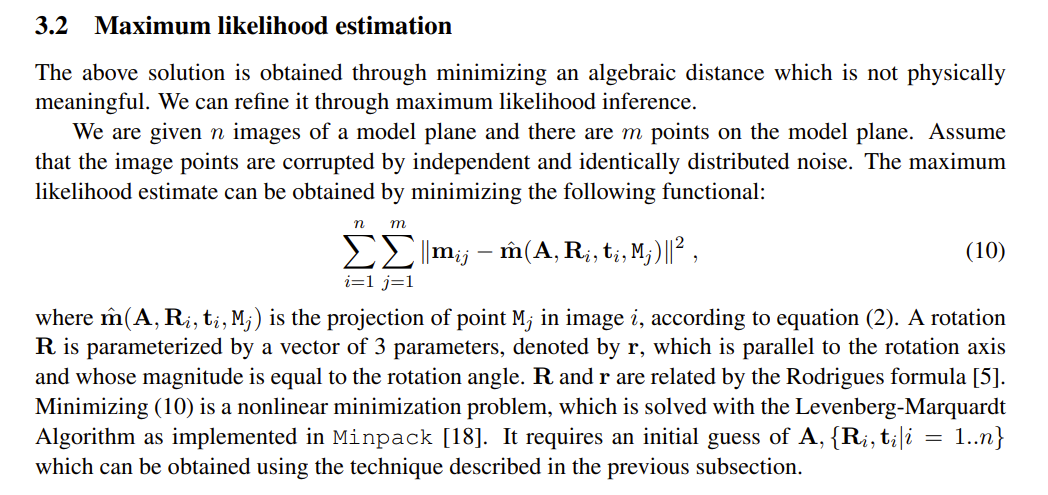

**Second Function - calculate_error_mean - To Evaluate Parameter**

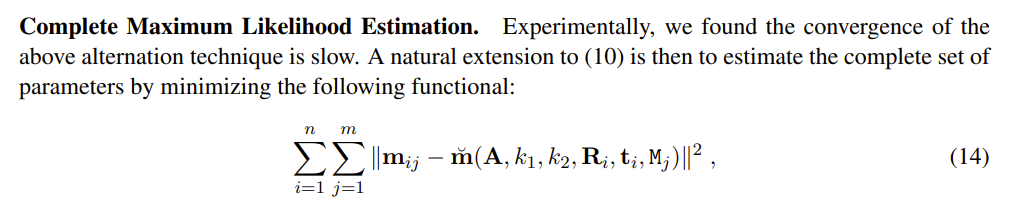

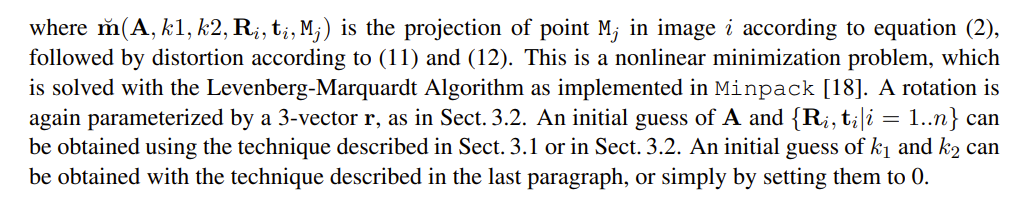

In [17]:
def calculate_error(radial_distortion_coponent, all_extrinsic_camera_parameter, image_corner_coordinate, real_world_point_coordinate):

    # Recover Matrix Form of Data
    intrinsic_camera_matrix, _ = recover_matrix_form(radial_distortion_coponent)
    
    # Component of Radial Distortion
    _, _, _, principle_point_coordinate_u, principle_point_coordinate_v, k_1, k_2 = radial_distortion_coponent

    error_matrix = []

    # For All Images
    for idx, image_corner in enumerate(image_corner_coordinate): 

        # Rotation & Translation for 3D Point
        extrinsic_camera_matrix = all_extrinsic_camera_parameter[idx]
        
        # Homography Matrix 
        rotation_translation_matrix = np.array([extrinsic_camera_matrix[:,0], extrinsic_camera_matrix[:,1], extrinsic_camera_matrix[:,3]]).reshape(3,3)
        rotation_translation_matrix = rotation_translation_matrix.T
        
        # Dot Product between Intrinsic Matrix and Homograhy Matrix
        homography_matrix = np.dot(intrinsic_camera_matrix, rotation_translation_matrix)

        image_total_error = 0

        for real_world_coordinate in range(real_world_point_coordinate.shape[0]):
            
            # Real World Point Homogeneous Coordinate
            real_world_point_2d_coordinate = real_world_point_coordinate[real_world_coordinate]
            real_world_point_2d_homogeneous_coordinate = np.array([real_world_point_2d_coordinate[0], real_world_point_2d_coordinate[1], 1]).reshape(3, 1)
            real_world_point_3d_homogeneous_coordinate = np.array([real_world_point_2d_coordinate[0], real_world_point_2d_coordinate[1], 0, 1]).reshape(4, 1)

            # Calculate Image Point Coordinate
            image_point_homogenous_coordinate = np.dot(extrinsic_camera_matrix, real_world_point_3d_homogeneous_coordinate)
            image_point_x =  image_point_homogenous_coordinate[0] / image_point_homogenous_coordinate[2]
            image_point_y = image_point_homogenous_coordinate[1] / image_point_homogenous_coordinate[2]

            # Calculate Radial Distortion r Square
            radial_distortion_r = image_point_x * image_point_x + image_point_y * image_point_y

            # Calculate Observed Image Coordinate
            observe_image_coordinate = image_corner[real_world_coordinate]
            observe_image_coordinate = np.array([observe_image_coordinate[0], observe_image_coordinate[1], 1], dtype = 'float').reshape(3,1)

            # Calculate Projected Image Coordinates
            projection_image_coordinate = np.dot(homography_matrix, real_world_point_2d_homogeneous_coordinate)
            projection_image_coordinate_u = projection_image_coordinate[0] / projection_image_coordinate[2]
            projection_image_coordinate_v = projection_image_coordinate[1] / projection_image_coordinate[2]

            # Radial Distortion Equation - Paper page 7 - dash of u, v
            real_observe_image_coordinate_u = projection_image_coordinate_u + (projection_image_coordinate_u - principle_point_coordinate_u) * (k_1 * radial_distortion_r + k_2 * radial_distortion_r**2)
            real_observe_image_coordinate_v = projection_image_coordinate_v + (projection_image_coordinate_v - principle_point_coordinate_v) * (k_1 * radial_distortion_r + k_2 * radial_distortion_r**2)
            
            # Projection of Real World Point in Image - Paper page 8 - dash of m
            projection_real_to_image_coordinate = np.array([real_observe_image_coordinate_u[0], real_observe_image_coordinate_v[0], 1], dtype = 'float').reshape(3,1)
            
            # Calculate Error between Observed Image Coordinate and Projection Coordinate
            error = np.linalg.norm((observe_image_coordinate - projection_real_to_image_coordinate), ord = 2)
            
            image_total_error += error

        error_matrix.append(image_total_error / 54)
    
    return np.array(error_matrix)

In [18]:
def calculate_error_mean(intrinsic_camera_parameter, radial_distortion_coefficient, all_extrinsic_camera_parameter, image_corner_coordinate, real_world_point_coordinate):

    error_matrix = []
    all_reprojection_point_coordinate = []
    
    # Component of Radial Distortion
    _, _, _, principle_point_coordinate_u, principle_point_coordinate_v, k_1, k_2 = get_radial_distortion_component(intrinsic_camera_parameter, radial_distortion_coefficient)
    
    # For All Images
    for idx, image_corner in enumerate(image_corner_coordinate): 

        # Rotation & Translation for a 3D Point
        extrinsic_camera_matrix = all_extrinsic_camera_parameter[idx]
        
        # Homography Matrix 
        rotation_translation_matrix = np.array([extrinsic_camera_matrix[:,0], extrinsic_camera_matrix[:,1], extrinsic_camera_matrix[:,3]]).reshape(3,3)
        rotation_translation_matrix = rotation_translation_matrix.T
        
        # Dot Product between Intrinsic Matrix and Homograhy Matrix
        homography_matrix = np.dot(intrinsic_camera_parameter, rotation_translation_matrix)

        image_total_error = 0
        reprojection_point_coordinate = []

        for real_world_coordinate in range(real_world_point_coordinate.shape[0]):
            
            # Real World Point Homogeneous Coordinate
            real_world_point_2d_coordinate = real_world_point_coordinate[real_world_coordinate]
            real_world_point_2d_homogeneous_coordinate = np.array([real_world_point_2d_coordinate[0], real_world_point_2d_coordinate[1], 1]).reshape(3, 1)
            real_world_point_3d_homogeneous_coordinate = np.array([real_world_point_2d_coordinate[0], real_world_point_2d_coordinate[1], 0, 1]).reshape(4, 1)

            # Calculate Projection Image Point Coordinate (Not Multiply Intrinsic Camera Parameter)
            image_point_homogenous_coordinate = np.dot(extrinsic_camera_matrix, real_world_point_3d_homogeneous_coordinate)
            image_point_x =  image_point_homogenous_coordinate[0] / image_point_homogenous_coordinate[2]
            image_point_y = image_point_homogenous_coordinate[1] / image_point_homogenous_coordinate[2]

            # Calculate Radial Distortion r Square
            radial_distortion_r = image_point_x * image_point_x + image_point_y * image_point_y

            # Calculate Observed Image Coordinate
            observe_image_coordinate = image_corner[real_world_coordinate]
            observe_image_coordinate = np.array([observe_image_coordinate[0], observe_image_coordinate[1], 1], dtype = 'float').reshape(3,1)

            # Calculate Projected Image Coordinates
            projection_image_coordinate = np.dot(homography_matrix, real_world_point_2d_homogeneous_coordinate)
            projection_image_coordinate_u = projection_image_coordinate[0] / projection_image_coordinate[2]
            projection_image_coordinate_v = projection_image_coordinate[1] / projection_image_coordinate[2]

            # Radial Distortion Equation - Paper page 7 - dash of u, v
            real_observe_image_coordinate_u = projection_image_coordinate_u + (projection_image_coordinate_u - principle_point_coordinate_u) * (k_1 * radial_distortion_r + k_2 * radial_distortion_r**2)
            real_observe_image_coordinate_v = projection_image_coordinate_v + (projection_image_coordinate_v - principle_point_coordinate_v) * (k_1 * radial_distortion_r + k_2 * radial_distortion_r**2)
            
            reprojection_point_coordinate.append([real_observe_image_coordinate_u, real_observe_image_coordinate_v])
              
            # Projection of Real World Point in Image - Paper page 8 - dash of m
            projection_real_to_image_coordinate = np.array([real_observe_image_coordinate_u[0], real_observe_image_coordinate_v[0], 1], dtype = 'float').reshape(3,1)

            # Calculate Error between Observed Image Coordinate and Projection Coordinate
            error = np.linalg.norm((observe_image_coordinate - projection_real_to_image_coordinate), ord = 2)
            
            image_total_error += error

        error_matrix.append(image_total_error)
        
        all_reprojection_point_coordinate.append(reprojection_point_coordinate)
        
    # Calculate Error Mean
    error_matrix = np.array(error_matrix)
    error_mean = np.sum(error_matrix) / (len(image_corner_coordinate) * real_world_point_coordinate.shape[0])
    
    return error_mean, all_reprojection_point_coordinate

##### **Main Part - Make One above them**

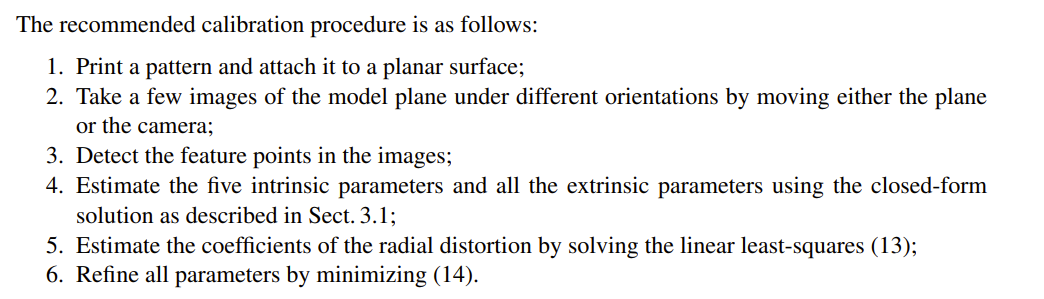

In [19]:
def main():
    
    # Image File Path & Result Corner File Path 
    image_folder_path = '../../data/chess_board_data_web'
    result_save_path = '../../data/chess_board_corner/result_image_web'

    file_list = os.listdir(image_folder_path)
    
    print("Loading images from ", image_folder_path)
    print("\n")
    
    images = []
    
    '''Load Image Files in the Directory'''
    
    for file in file_list:
        
        # Image File Path 
        image_file_path = image_folder_path + "/" + file
        
        # Load Image 
        image = cv2.imread(image_file_path)
        
        # Save Image in List 
        if image is not None:
            
            images.append(image)	
            		
        else:
            
            print("There is no Image File ", image)


    '''Find Corner Coordinate in Image'''
    
    # Number of Corner along the axis
    num_x, num_y = [9, 6]
    
    # All of Images Corner Coordinate
    all_images_corner_coordinate = get_chess_board_corner(images = images, num_x = num_x, num_y = num_y)

    # Real World Coordinate of Corners
    real_world_corner_coordinate = get_world_points(square_length = 10, num_x = num_x, num_y = num_y)
    
    # Display Corners using cv
    visualize_corner(images = images, corner_list = all_images_corner_coordinate, num_x = num_x, num_y = num_y, save_path = result_save_path)
    
    
    '''Homography Matrix & B Matrix & Intrinsix Camera Parameter & Extrinsic Camera Parameter'''
    
    # Calculate Homography Matrix 
    print('Calculate Homography for ' + str(len(images)) +  ' Images')
    print('\n')
    
    all_homography_matrix = get_all_homography_matrix(image_corner = all_images_corner_coordinate, square_length = 10, num_x = num_x, num_y = num_y)
    
    print('==========Homography Matrix for all of the Images=========')
    print('\n')
    
    for idx, homography_matrix in enumerate(all_homography_matrix):
        print(f"==============Camera {idx+1} Homography Matrix==============")
        print(np.array(homography_matrix))
        print('\n')
    
    
    # Caclulate B Matrix 
    print('Calculate B Matrix to Calculate Intrinsic Camera Parameter')
    
    b_matrix = get_b_matrix_b_vector(all_homography_matrix_list = all_homography_matrix)
    
    print('========================B Matrix=========================')
    print(b_matrix)
    print('\n')
    
    # Calculate Intrinsic Camera Parameter
    print('Calculate Intrinsic Camera Parameter')
    
    intrinsic_camera_parameter = get_intrinsic_parameter_camera(b_matrix = b_matrix)
    
    print('===============Intrinsic Camera Parameter================')
    print(intrinsic_camera_parameter)
    print('\n')
    
    # Calculate Extrinsic Camera Parameter
    print('Calculate Extrinsic Camera Parameter')
    print('\n')
    
    extrinsic_camera_parameter = get_extrinsic_parameter_camera(intrinsic_parameter_matrix = intrinsic_camera_parameter, all_homography_matrix_list = all_homography_matrix)
    
    print('====Extrinsic Camera Parameter for all of the Images=====')
    print('\n')
    
    for idx, extrinsic_matrix in enumerate(extrinsic_camera_parameter):
        print(f"=================Camera {idx+1} Extrinsic Camera Matrix=================")
        print(np.array(extrinsic_matrix))
        print('\n')
    
    
    '''Setting Radial Distortion Coefficient'''
    
    # Setting 0 along the Paper page 8, line 6
    init_radial_distortion_coefficient = np.array([0, 0]).reshape(2, 1)
    
    
    '''Optimize all Parameters'''
    
    print('Starting Optimize all of the Parameters')
    print('\n')
    
    # Bring Radial Distortion Components
    radial_distortion_component = get_radial_distortion_component(intrinsic_camera_parameter = intrinsic_camera_parameter, radial_distortion_coefficient = init_radial_distortion_coefficient)

    # Do Optimization using Scipy - x0: Initial Value & lm: Levenberg-Marquardt Algorithm
    optim_res = least_squares(fun = calculate_error, x0 = radial_distortion_component, method = "lm", args = [extrinsic_camera_parameter, all_images_corner_coordinate, real_world_corner_coordinate])
    
    # Update Intrinsic Camera Parameter & Radial Distortion Coefficient
    update_radial_distortion_componet = optim_res.x
    
    # Recover Matrix Form 
    all_of_component_matrix = recover_matrix_form(radial_distortion_coponent = update_radial_distortion_componet)
    
    # Divide into Intrinsic Camera Parameter and Radial Distortion Coefficient
    update_intrinsic_camera_parameter = all_of_component_matrix[0]
    update_radial_distortion_coefficient = all_of_component_matrix[1]
    
    
    '''Compare Before and After Optimization'''
    
    # Calculate Error Before Optimization
    previous_error, _ = calculate_error_mean(intrinsic_camera_parameter = intrinsic_camera_parameter, radial_distortion_coefficient = init_radial_distortion_coefficient, 
                                             all_extrinsic_camera_parameter = extrinsic_camera_parameter, image_corner_coordinate = all_images_corner_coordinate, 
                                             real_world_point_coordinate = real_world_corner_coordinate)
    
    # Update Extrinsic Camera Parameter
    update_extrinsic_camera_parameter = get_extrinsic_parameter_camera(intrinsic_parameter_matrix = update_intrinsic_camera_parameter, all_homography_matrix_list = all_homography_matrix)
    
    # Calculate Error After Optimization
    update_error, update_projection_coordinate = calculate_error_mean(intrinsic_camera_parameter = update_intrinsic_camera_parameter, radial_distortion_coefficient = update_radial_distortion_coefficient, 
                                                all_extrinsic_camera_parameter = update_extrinsic_camera_parameter, image_corner_coordinate = all_images_corner_coordinate, 
                                                real_world_point_coordinate = real_world_corner_coordinate)
    
    print('================Error Before Optimization================')
    print('Error before the optimization: ', previous_error)
    print('\n')
    
    print('=================Error After Optimization================')
    print('Error after the optimization: ', update_error)
    print('\n')
    
    print('=============New Intrinsic Camera Parameter==============')
    print(update_intrinsic_camera_parameter)
    print('\n')
    
    
    '''Visualization Our Code Result'''
    
    # Setting Parameters
    update_intrinsic_camera_parameter_visualization = np.array(update_intrinsic_camera_parameter, np.float32).reshape(3, 3)
    radial_distortion_coefficient_visualization = np.array([update_radial_distortion_coefficient[0][0], update_radial_distortion_coefficient[1][0], 0, 0], np.float32)
    
    # Visualization
    for idx, projected_image_points in enumerate(update_projection_coordinate):
        
        # Generate Undistortion Image using cv
        image = cv2.undistort(images[idx], cameraMatrix = update_intrinsic_camera_parameter_visualization, distCoeffs = radial_distortion_coefficient_visualization)
        
        for projected_image_point in projected_image_points:
            
            coordinate_x = int(projected_image_point[0][0])
            coordinate_y = int(projected_image_point[1][0])

            image = cv2.circle(img = image, center = (coordinate_x, coordinate_y), radius = 5, color = (255, 0, 0), thickness = 3)
        
        # Setting Save File Path
        filename = result_save_path + r'\final image_'+ str(idx) + "_reprojection.png"
        
        cv2.imwrite(filename, image)

##### **if \_\_name\_\_ == '\_\_main\_\_':**

In [21]:
main()

Loading images from  ../../data/chess_board_data_web


Calculate Homography for 9 Images


==========Homography Matrix for all of the Images=========


==============Camera 1 Homography Matrix==============
[[ 8.66388850e+00 -3.92443362e-01  5.83601276e+02]
 [ 9.48077106e-01  7.67279518e+00  1.57734364e+02]
 [ 1.57483136e-03  5.21804255e-05  1.00000000e+00]]


==============Camera 2 Homography Matrix==============
[[ 1.02887595e+01 -1.05738552e+00  5.18483167e+02]
 [ 1.90778292e+00  8.97015823e+00  1.14663947e+02]
 [ 2.28010747e-03  1.89422539e-04  1.00000000e+00]]


==============Camera 3 Homography Matrix==============
[[ 4.70618387e+00  7.59263001e-01  4.02327865e+02]
 [-8.24676933e-01  7.33429897e+00  1.71496474e+02]
 [-2.60700771e-03  7.63385586e-04  1.00000000e+00]]


==============Camera 4 Homography Matrix==============
[[ 6.93552512e+00 -2.57228549e+00  2.14842633e+02]
 [ 9.87621268e-02  5.94925535e+00  1.44104435e+02]
 [-1.29572521e-03 -3.11253252e-03  1.00000000e+00]]


====